Movie Title and Review Analysis 
- Can we train a machine learning model to predict the popularity of movies based on the learnings from movie titles? 
- Can we do it within reasonable time with reasonable accuracy?
- Can we optimize the model training in a principled fashion?


In [1]:
import pandas as pd
import collections
import os
import nltk
import numpy as np
import matplotlib.pyplot as plt
import string

nltk.download("punkt")
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ebalgza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(os.listdir("movies"))


['movies.csv', 'ratings.csv.001', 'ratings.csv.002', 'ratings.csv.003', 'ratings.csv.004', 'ratingsorig.csv']


In [3]:
#Let's load the data
# If you are like me, and the laptop can't process 500 megs of rating, use a slice
# Feel free to use the whole set if you have da powah, just uncomment last line
movies = pd.read_csv("movies/movies.csv", sep=",")
ratings = pd.read_csv("./movielens/ratingsorig.csv.001", sep = ",") 
#ratings = pd.read_csv("movies/ratings.csv.001") #get the 
#ratings = pd.read_csv("movies/ratingsorig.csv") #my laptop can't handle the size

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Sum the number of positive reviews for each movie


In [6]:
#How do we define a really good rating?
#Not just a plain old - yeah it was alright kinda movie
#Let's make it way above average, 4.5 and 5
positive_ratings = ratings['rating'] > 4
positive_ratings[6001266:6001276]

6001266    False
6001267    False
6001268     True
6001269    False
6001270     True
6001271    False
6001272    False
6001273    False
6001274    False
6001275     True
Name: rating, dtype: bool

In [7]:
#I want to see those raving good ratigs
good_film_ratings = ratings[positive_ratings]
good_film_ratings[105:115]

,userId,movieId,rating,timestamp
414,3,2985,5.0,944919729
416,3,3033,5.0,944919729
417,3,3039,5.0,944919189
422,3,5060,5.0,944917450
439,4,454,5.0,840878944
450,4,733,5.0,840879322
452,5,11,5.0,851527751
455,5,62,5.0,851526935
459,5,141,5.0,851526935
460,5,150,5.0,851527514


In [8]:
#What does this look like for one particular movie?
movie1196_filter = good_film_ratings['movieId'] == 1196
movies1196 = good_film_ratings[movie1196_filter]
movies1196.head()

,userId,movieId,rating,timestamp
30,1,1196,4.5,1112484742
190,2,1196,5.0,974821014
286,3,1196,5.0,944917859
512,5,1196,5.0,851617674
602,7,1196,5.0,1011204572


In [9]:
good_film_ratings.head()

,userId,movieId,rating,timestamp
30,1,1196,4.5,1112484742
31,1,1198,4.5,1112484624
131,1,4993,5.0,1112484682
142,1,5952,5.0,1112484619
158,1,7153,5.0,1112484633


In [10]:
#Feel free to take a look at the way the data currently looks
movies.head()
#ratings.head()
#good_film_ratings.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
#Let's sum up the excellent ratings for the movies
number_of_excellent_ratings = good_film_ratings.groupby(by = "movieId")['rating'].count()
sum_of_excellent_ratings = good_film_ratings.groupby(by = "movieId")['rating'].sum()

In [12]:
number_of_excellent_ratings[35:45]
#sum_of_excellent_ratings[35:45] #uncomment this line to see the overall weight these ratings carry

movieId
36    2010
37       4
38      28
39    1096
40      55
41     363
42      48
43      95
44     160
45     325
Name: rating, dtype: int64

In [13]:
# But a movie is not good must because it has positive reviews
# It needs to have a whole lot more excellent reviews than negatives
# Let's create a negative ratings list function
print("For reference, here are the positive ratings:")
print(positive_ratings[6001265:6001270])

For reference, here are the positive ratings:
6001265    False
6001266    False
6001267    False
6001268     True
6001269    False
Name: rating, dtype: bool


In [14]:
#Any ratings that is less than 2 is truly a baaad one
print("Negative reviews:")
negative_ratings = ratings['rating'] < 2
negative_ratings.head()

Negative reviews:


0    False
1    False
2    False
3    False
4    False
Name: rating, dtype: bool

In [15]:
#I want to see those horrendously bad ratigs
bad_film_ratings = ratings[negative_ratings]
bad_film_ratings[105:115]

,userId,movieId,rating,timestamp
3297,28,185,1.0,834093021
3298,28,196,1.0,834093089
3302,28,266,1.0,834093066
3315,28,417,1.0,834092871
3323,28,590,1.0,834092660
3434,29,371,1.0,835638228
3504,30,163,1.0,1204791725
3505,30,168,0.5,1204791801
3510,30,555,1.5,1204791757
3538,31,527,0.5,1424733598


In [16]:
#Let's sum up the bad ratings for the movies
number_of_bad_ratings = bad_film_ratings.groupby(by = "movieId")['rating'].count()
sum_of_bad_ratings = bad_film_ratings.groupby(by = "movieId")['rating'].sum()

In [17]:
number_of_bad_ratings
#sum_of_bad_ratings # Uncomment this line to see the total negative weight

movieId
1          274
2          419
3          280
4          106
5          290
6          102
7          175
8           22
9          111
10         246
11         104
12         225
13          26
14          69
15         146
16          78
17         148
18         115
19        1420
20         116
21         218
22         131
23          79
24         191
25         301
26          22
27          17
28          15
29          80
30          12
          ... 
128632       1
128736       1
128914       1
128975       2
129015       1
129030       2
129354       2
129370       1
129428       1
129456       1
129514       1
129699       1
129707       1
129822       1
129834       1
129937       1
130052       1
130075       2
130466       1
130490       2
130496       1
130498       1
130500       1
130502       1
130506       1
130508       1
130510       1
130672       1
130804       1
130836       1
Name: rating, Length: 13088, dtype: int64

In [18]:
# Let's turn the sums into a combined score that expresses the overall quality, so to say, 
# of each movie based on the most positive and most negative ratings
print(sum_of_excellent_ratings.head())
print(sum_of_bad_ratings.head())

movieId
1    23501.5
2     2988.0
3     1827.5
4      345.0
5     1477.0
Name: rating, dtype: float64
movieId
1    282.0
2    452.5
3    284.5
4    108.0
5    285.5
Name: rating, dtype: float64


In [19]:
#Let's leave mediocrity behind.
# A truly wonderful movie is defined by the weight of outstanding reviews
# at least for my purposes 
quality_score = sum_of_excellent_ratings - sum_of_bad_ratings 

qs = quality_score.to_frame()
qs.head()

,rating
movieId,
1,23219.5
2,2535.5
3,1543.0
4,237.0
5,1191.5


In [20]:
qs = qs.rename(columns={"rating":"Quality_Score"})
qs.head()

,Quality_Score
movieId,
1,23219.5
2,2535.5
3,1543.0
4,237.0
5,1191.5


In [21]:
#Let's get the movies together with their awesomeness scores
ratings_with_quality_score = movies.merge(qs, on="movieId", how="left")

In [22]:
ratings_with_quality_score.head()

,movieId,title,genres,Quality_Score
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23219.5
1,2,Jumanji (1995),Adventure|Children|Fantasy,2535.5
2,3,Grumpier Old Men (1995),Comedy|Romance,1543.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,237.0
4,5,Father of the Bride Part II (1995),Comedy,1191.5


In [23]:
#What are the first 1000 highest ranking movies based on the overwhelming positive reviews
ratings_with_quality_score.sort_values(by = "Quality_Score", ascending=False)[:1000]


,movieId,title,genres,Quality_Score
315,318,"Shawshank Redemption, The (1994)",Crime|Drama,59721.5
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,50944.0
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,42472.5
523,527,Schindler's List (1993),Drama|War,41443.0
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,40297.0
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,40294.5
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,39580.5
2486,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,38372.5
843,858,"Godfather, The (1972)",Crime|Drama,37075.5
108,110,Braveheart (1995),Action|Drama|War,33137.0


In [24]:
# Let's define a movie as excellent if its positive review weight is 
# at least 1000 scores higher than its negative weight
excellence_score=999
ratings_with_quality_score["excellent_film"] = np.where(ratings_with_quality_score["Quality_Score"] > excellence_score, True, False)

In [25]:
ratings_with_quality_score.head()
#ratings_with_quality_score.shape
#ratings_with_quality_score.tail()

,movieId,title,genres,Quality_Score,excellent_film
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23219.5,True
1,2,Jumanji (1995),Adventure|Children|Fantasy,2535.5,True
2,3,Grumpier Old Men (1995),Comedy|Romance,1543.0,True
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,237.0,False
4,5,Father of the Bride Part II (1995),Comedy,1191.5,True


In [26]:
stop_words = list(string.punctuation) 
stop_words += nltk.corpus.stopwords.words("english")
stop_words += ["1","2","3","4","5","6","7","8","9","0","the","The", "'s", "'re"]
stop_words += ["1990","1995","1996","1997","1998","1999","1994","1993","1992","1991"]
stop_words += ["1980","1985","1986","1987","1988","1989","1984","1983","1982","1981"]
stop_words += ["1950","1955","1956","1957","1958","1959","1954","1953","1952","1951"]
stop_words += ["1960","1965","1966","1967","1968","1969","1964","1963","1962","1961"]
stop_words += ["1970","1975","1976","1977","1978","1979","1974","1973","1972","1971"]
stop_words += ["1940","1945","1946","1947","1948","1949","1944","1943","1942","1941"]
stop_words += ["1940","1945","1946","1947","1948","1949","1944","1943","1942","1941"]
stop_words += ["1930","1935","1936","1937","1938","1939","1934","1933","1932","1931"]
stop_words += ["2000","2005","2006","2007","2008","2009","2004","2003","2002","2001"]
stop_words += ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019"]


In [27]:
def build_bag_of_words_features_filtered(words):
    return {
        word:1 for word in words \
        if not word in stop_words}


In [28]:
nltk.word_tokenize(ratings_with_quality_score.iloc[[1]]["title"].to_string())
#build_bag_of_words_features_filtered(ratings_with_quality_score.iloc[[2]]["title"])

['1', 'Jumanji', '(', '1995', ')']

In [29]:
def tokenize_title(line):
    return nltk.word_tokenize(line)

In [30]:
tokenize_title(ratings_with_quality_score.iloc[[1]]["title"].to_string())

['1', 'Jumanji', '(', '1995', ')']

In [31]:
def tokenize_and_filter_title(title):
    all_words = tokenize_title(title)
    filtered_words = build_bag_of_words_features_filtered(all_words)
    #print(filtered_words)
    return filtered_words

for title in ratings_with_quality_score["title"]:
    tokenize_and_filter_title(title)
    
ratings_with_quality_score.head()

,movieId,title,genres,Quality_Score,excellent_film
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23219.5,True
1,2,Jumanji (1995),Adventure|Children|Fantasy,2535.5,True
2,3,Grumpier Old Men (1995),Comedy|Romance,1543.0,True
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,237.0,False
4,5,Father of the Bride Part II (1995),Comedy,1191.5,True


In [32]:
list(ratings_with_quality_score)


['movieId', 'title', 'genres', 'Quality_Score', 'excellent_film']

In [33]:
def create_target_df(ratings_with_quality_score):
    data = []
    for movie in ratings_with_quality_score.itertuples(index=True, name='title'):
        title = getattr(movie, "title")
        bow = tokenize_and_filter_title(title)
        is_excellent = getattr(movie, "excellent_film")
        data += [(bow,is_excellent)]
        
    return data




In [34]:
target = (create_target_df(ratings_with_quality_score))




In [35]:
target[8]

({'Sudden': 1, 'Death': 1}, False)

In [36]:
targetlist = list(target)

targetlist[8]

({'Sudden': 1, 'Death': 1}, False)

In [37]:
from nltk.classify import NaiveBayesClassifier
split=10000

In [38]:
success_classifier = NaiveBayesClassifier.train(target[:split])

In [39]:
nltk.classify.util.accuracy(success_classifier, target[:split])*100

84.38

In [40]:
import random
def montecarlo_classifier():
    split = random.randint(0,(len(target)-1))
    success_classifier = NaiveBayesClassifier.train(target[:split])
    accuracy = round(nltk.classify.util.accuracy(success_classifier, target[split:])*100,2)
    #print("{}{}{}".format("accurary: ",accuracy,"\n\n"))
    #print("{}{}".format("split: ",split))
    return split,accuracy
    

In [41]:
def montecarlo_runner(iterations):
    perf=[]
    for iteration in range(iterations):
        perf.append(montecarlo_classifier())
        
    return perf

In [42]:
number_of_runs = 10
perf=montecarlo_runner(number_of_runs)
print(perf)

[(6792, 87.13), (26071, 91.3), (1507, 81.26), (8682, 88.66), (17549, 88.88), (13011, 88.48), (17103, 88.84), (2648, 83.06), (18227, 88.3), (8025, 87.95)]


In [43]:
sorted_accuracy = sorted(perf,key=lambda x: x[1], reverse=False)
sorted_accuracy[1]

transposed_values=[]
for sample,accuracy in sorted_accuracy:
    transposed_values.append([accuracy,sample])
    
transposed_values

[[81.26, 1507],
 [83.06, 2648],
 [87.13, 6792],
 [87.95, 8025],
 [88.3, 18227],
 [88.48, 13011],
 [88.66, 8682],
 [88.84, 17103],
 [88.88, 17549],
 [91.3, 26071]]

Text(0.5,0,'Prediction Accuracy')

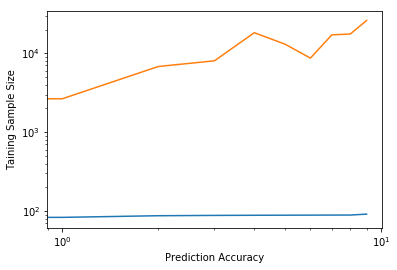

In [44]:
plt.loglog(transposed_values)
plt.ylabel("Taining Sample Size")
plt.xlabel("Prediction Accuracy")

([array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])],
 array([   81.26 ,  2680.234,  5279.208,  7878.182, 10477.156, 13076.13 ,
        15675.104, 18274.078, 20873.052, 23472.026, 26071.   ]),
 <a list of 10 Lists of Patches objects>)

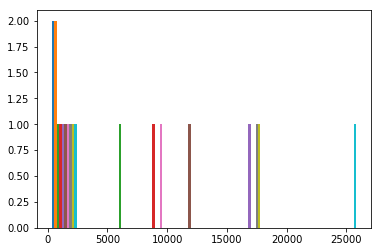

In [45]:
plt.hist(transposed_values)

In [46]:
for point in sorted_accuracy:
    print(point[0])
    print(point[1])

1507
81.26
2648
83.06
6792
87.13
8025
87.95
18227
88.3
13011
88.48
8682
88.66
17103
88.84
17549
88.88
26071
91.3


In [47]:
print(sorted_accuracy)
print(transposed_values)

retransposed = list(zip(*transposed_values))
print(retransposed)

[(1507, 81.26), (2648, 83.06), (6792, 87.13), (8025, 87.95), (18227, 88.3), (13011, 88.48), (8682, 88.66), (17103, 88.84), (17549, 88.88), (26071, 91.3)]
[[81.26, 1507], [83.06, 2648], [87.13, 6792], [87.95, 8025], [88.3, 18227], [88.48, 13011], [88.66, 8682], [88.84, 17103], [88.88, 17549], [91.3, 26071]]
[(81.26, 83.06, 87.13, 87.95, 88.3, 88.48, 88.66, 88.84, 88.88, 91.3), (1507, 2648, 6792, 8025, 18227, 13011, 8682, 17103, 17549, 26071)]


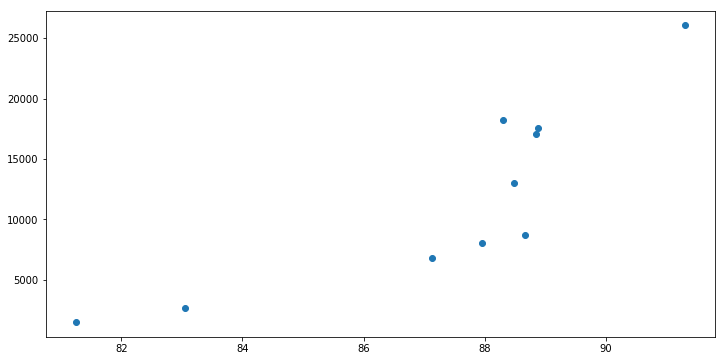

In [48]:
plt.figure(figsize = (12,6))
plt.scatter(retransposed[0],retransposed[1])
plt.show()

In [49]:
perf=montecarlo_runner(100)

In [50]:
data = list(zip(*perf))
data

[(14518,
  13679,
  10985,
  24053,
  23801,
  16887,
  23125,
  6985,
  26425,
  7753,
  6960,
  25249,
  26940,
  11533,
  8945,
  16775,
  9073,
  9424,
  3124,
  23316,
  19515,
  15672,
  9030,
  7845,
  17205,
  25657,
  23117,
  2094,
  19574,
  1542,
  17013,
  4249,
  4210,
  3994,
  2243,
  10834,
  3363,
  23077,
  8594,
  8224,
  22696,
  1194,
  7733,
  21436,
  16672,
  13671,
  3345,
  4954,
  11491,
  23580,
  24428,
  14639,
  7088,
  223,
  11513,
  1220,
  3743,
  17661,
  18299,
  3710,
  24251,
  2397,
  18835,
  8032,
  5000,
  23001,
  18313,
  10528,
  12428,
  11905,
  8639,
  26586,
  12158,
  10702,
  14641,
  7062,
  23808,
  10812,
  22538,
  14805,
  14898,
  3991,
  5549,
  6973,
  20502,
  15343,
  3761,
  9807,
  12779,
  25419,
  19152,
  1461,
  5612,
  1770,
  2147,
  13474,
  23173,
  8952,
  23499,
  19019),
 (88.82,
  88.72,
  87.98,
  90.82,
  90.57,
  88.71,
  90.37,
  87.3,
  90.39,
  87.47,
  87.29,
  91.18,
  90.53,
  88.36,
  88.7,
  88.68,


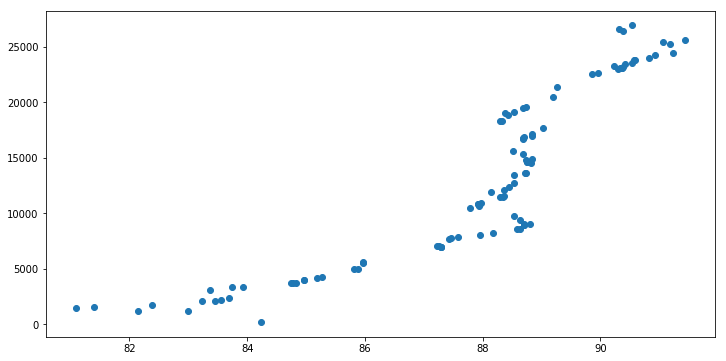

In [51]:
plt.figure(figsize = (12,6))
plt.scatter(data[1],data[0])
plt.show()

In [52]:
def go_the_whole_hog(iterations):
    raw_data=montecarlo_runner(iterations)
    serialized_data = list(zip(*raw_data))
    plt.figure(figsize = (12,6))
    plt.xlabel("Taining Sample Size")
    plt.ylabel("Prediction Accuracy")
    plt.scatter(serialized_data[0],serialized_data[1])
    plt.show()

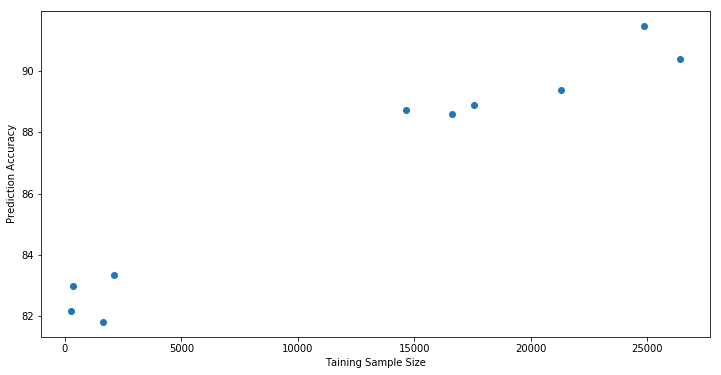

In [53]:
go_the_whole_hog(10)

In [54]:
def generate_data_for_(iterations):
    raw_data=montecarlo_runner(iterations)
    serialized_data = list(zip(*raw_data))
    return serialized_data

def visualize_data(data):
    plt.figure(figsize = (12,6))
    plt.ylabel("Taining Sample Size")
    plt.xlabel("Prediction Accuracy")
    plt.scatter(data[1],data[0])
    plt.show()

In [55]:
def how_big_should_my_sample_be(iterations):
    data = generate_data_for_(iterations)
    visualize_data(data)

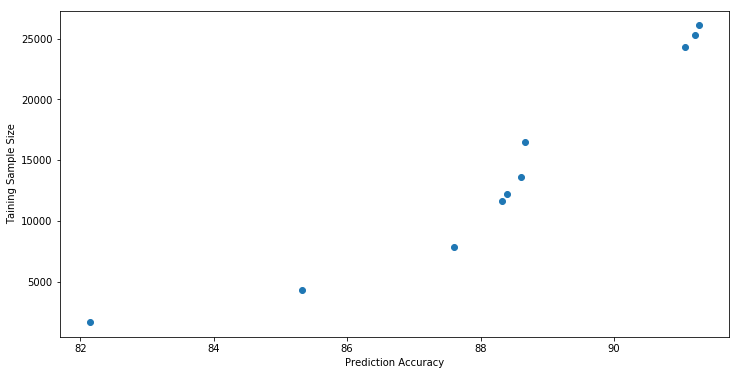

In [56]:
how_big_should_my_sample_be(10)

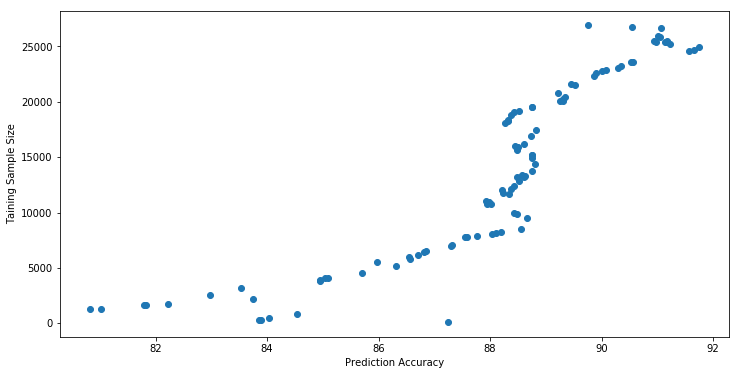

In [57]:
how_big_should_my_sample_be(100)

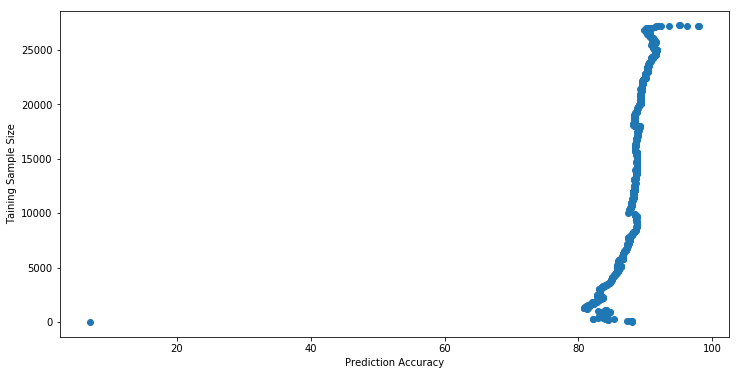

In [58]:
how_big_should_my_sample_be(1000)